In [ ]:
!pip install muspy
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 78.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 2.1 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=19541a200c7e8d1c7a0e0c546dcbfdb36a06b7ac6edca37d552f5ff239979ae3
  Stored in directory: /root/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
Successfully built pretty-midi
  Attempting uninstall: music21
    Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0
Re

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
major="/content/drive/MyDrive/Colab-Notebooks/Chef oeuvre/major_parts"

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [ ]:
data_dir = pathlib.Path(major)
filenames = glob.glob(str(data_dir/'*.mid*'))
print('Number of files:', len(filenames))

Number of files: 317


In [ ]:
sample_file = filenames[52]
print(sample_file)

/content/drive/MyDrive/Colab-Notebooks/Chef oeuvre/major_parts/Wake Me Gently (Album Version)_transpose.mid


In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    pitch_mod = note.pitch%12
    notes['pitch'].append(pitch_mod)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})


In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()


,pitch,start,end,step,duration
0,0,3.107157,5.060336,0.000000,1.953179
1,7,3.496767,5.060336,0.389610,1.563569
2,7,3.886378,4.862967,0.389610,0.976590
3,2,4.275989,4.862967,0.389611,0.586979
4,4,5.060336,5.829567,0.784347,0.769231


In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
num_files = 50
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)


In [ ]:
print(all_notes)

      pitch       start         end      step  duration
0         2    0.000000    0.206897  0.000000  0.206897
1        11    0.000000    0.206897  0.000000  0.206897
2         8    0.000000    0.206897  0.000000  0.206897
3         4    0.000000    0.206897  0.000000  0.206897
4         8    0.000000    0.827586  0.000000  0.827586
...     ...         ...         ...       ...       ...
2080     11  165.833496  166.083496  0.000000  0.250000
2081      2  165.833496  166.083496  0.000000  0.250000
2082      4  165.833496  166.083496  0.000000  0.250000
2083      7  166.750000  166.916504  0.916504  0.166504
2084      7  166.750000  166.916504  0.000000  0.166504

[68765 rows x 5 columns]


In [ ]:
key_order = ['pitch','step','duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 12,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return inputs, labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

seq_length = 25
vocab_size = 12
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

train_ds.element_spec

Number of notes parsed: 68765


(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(12)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(12, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 12)           768         ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            13          ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 12)           156         ['lstm[0][0]']                   
                                                                                              

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

1074/1074 [==============================] - 21s 4ms/step - loss: 9.7442 - duration_loss: 3.2029 - pitch_loss: 2.5230 - step_loss: 4.0183


{'loss': 9.744220733642578,
 'duration_loss': 3.2029194831848145,
 'pitch_loss': 2.523000717163086,
 'step_loss': 4.018302917480469}

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]


Epoch 1/20
1074/1074 [==============================] - 10s 7ms/step - loss: 2.6465 - duration_loss: 0.1287 - pitch_loss: 2.3216 - step_loss: 0.1962
Epoch 2/20
1074/1074 [==============================] - 8s 7ms/step - loss: 2.5877 - duration_loss: 0.1124 - pitch_loss: 2.3017 - step_loss: 0.1736
Epoch 3/20
1074/1074 [==============================] - 8s 7ms/step - loss: 2.5816 - duration_loss: 0.1118 - pitch_loss: 2.2974 - step_loss: 0.1724
Epoch 4/20
1074/1074 [==============================] - 8s 7ms/step - loss: 2.5741 - duration_loss: 0.1110 - pitch_loss: 2.2930 - step_loss: 0.1701
Epoch 5/20
1074/1074 [==============================] - 8s 8ms/step - loss: 2.5656 - duration_loss: 0.1105 - pitch_loss: 2.2861 - step_loss: 0.1690
Epoch 6/20
1074/1074 [==============================] - 10s 9ms/step - loss: 2.5570 - duration_loss: 0.1103 - pitch_loss: 2.2782 - step_loss: 0.1686
Epoch 7/20
1074/1074 [==============================] - 8s 7ms/step - loss: 2.5496 - duration_loss: 0.1102 - p

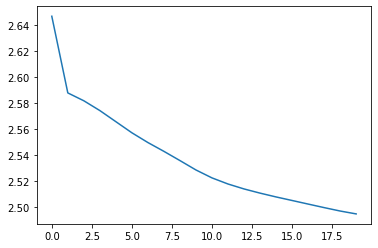

In [ ]:
epochs = 20

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()


In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)


In [ ]:
temperature = 2.0
num_predictions = 120

raw_notes = midi_to_notes(filenames[75])
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length])

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  pitch = pitch % 12 +60
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

print(generated_notes.head(50))

1/1 [==============================] - 0s 18ms/step
    pitch      step  duration     start       end
0      69  0.149788  0.366437  0.149788  0.516225
1      68  0.074118  0.221613  0.223906  0.445520
2      60  0.042670  0.123904  0.266576  0.390480
3      71  0.042883  0.090255  0.309459  0.399714
4      67  0.017207  0.047586  0.326666  0.374252
5      67  0.013863  0.044878  0.340530  0.385408
6      70  0.020322  0.044316  0.360852  0.405167
7      71  0.020047  0.036438  0.380899  0.417336
8      64  0.017608  0.041873  0.398506  0.440379
9      62  0.025667  0.042291  0.424173  0.466464
10     64  0.030539  0.035913  0.454711  0.490624
11     62  0.028464  0.028946  0.483175  0.512122
12     67  0.025093  0.026767  0.508269  0.535035
13     62  0.022314  0.048820  0.530582  0.579402
14     67  0.029305  0.043648  0.559887  0.603535
15     70  0.031773  0.036933  0.591660  0.628593
16     67  0.029044  0.014054  0.620704  0.634758
17     63  0.018657  0.000000  0.639361  0.63936

In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)


Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
from google.colab import files
files.download(out_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>